In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

RSEED = 25

In [57]:
df = pd.read_csv("data/train.csv")


In [58]:

print(df.head())
print(df.shape)
print(df.isnull().sum())
print(df.dtypes)

           ID       DATOP     FLTID DEPSTN ARRSTN                  STD   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0  
(107833, 10)
ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
target    0
dtype: int64
ID         object
DATOP      object
FLTID      object
DEPSTN     object
ARRSTN     object
STD        ob

In [59]:

df.nunique()
#df['AC'].unique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [60]:
print(df['STATUS'].unique())

col_entries = ['ATA', 'DEP', 'RTR', 'SCH', 'DEL']

for i in col_entries:
    print(f"Number of entries of {i}: {df[df['STATUS'] == i].shape[0]}")
    print(f"Mean: {df[df['STATUS'] == i]['target'].mean()}")
    print(f"Median: {df[df['STATUS'] == i]['target'].median()}")

['ATA' 'DEP' 'RTR' 'SCH' 'DEL']
Number of entries of ATA: 93679
Mean: 55.65509879482061
Median: 19.0
Number of entries of DEP: 467
Mean: 44.46252676659529
Median: 0.0
Number of entries of RTR: 294
Mean: 69.89455782312925
Median: 17.0
Number of entries of SCH: 13242
Mean: 0.0
Median: 0.0
Number of entries of DEL: 151
Mean: 0.0
Median: 0.0


In [61]:
df['STA'] = df['STA'].str.replace('.',':')

<Axes: >

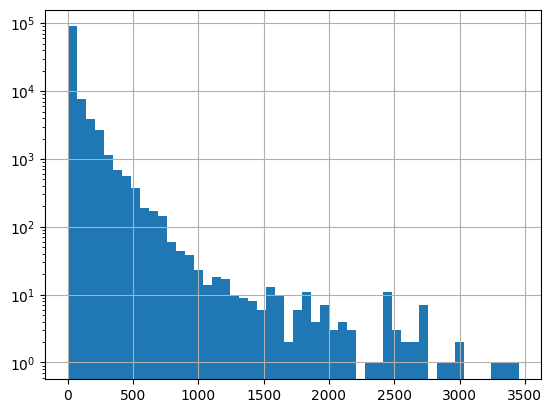

In [62]:
df['target'].hist(bins = 50, log =True)

In [63]:

df.head(20)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18:15:00,ATA,TU 736IOP,53.0
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09:00:00,ATA,TU 32AIMH,10.0
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09:55:00,ATA,TU 32AIMI,15.0
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09:00:00,ATA,TU 32AIMC,16.0
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09:15:00,ATA,TU 31AIMK,21.0


In [65]:
df['DATOP'] = pd.to_datetime(df['DATOP'], format='%Y-%m-%d')
df['STD'] = pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] = pd.to_datetime(df['STA'], format='%Y-%m-%d %H:%M:%S')

In [66]:

# extract year, month, dayofweek and hour information out of column publish_time and build new column for each
df["DATOP_year"]=df["DATOP"].dt.year
df["DATOP_month"]=df["DATOP"].dt.month
df["DATOP_day"]=df["DATOP"].dt.dayofweek+1
#df["publish_hour"]=df["publish_time"].dt.hour

In [67]:
df['flight_time'] = (df['STA'] - df['STD']).dt.total_seconds() / 60

In [68]:

df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,DATOP_year,DATOP_month,DATOP_day,flight_time
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,2016,1,7,145.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2016,1,3,110.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,2016,1,6,155.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,2016,1,7,170.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,2016,1,7,80.0


[2016 2017 2018]


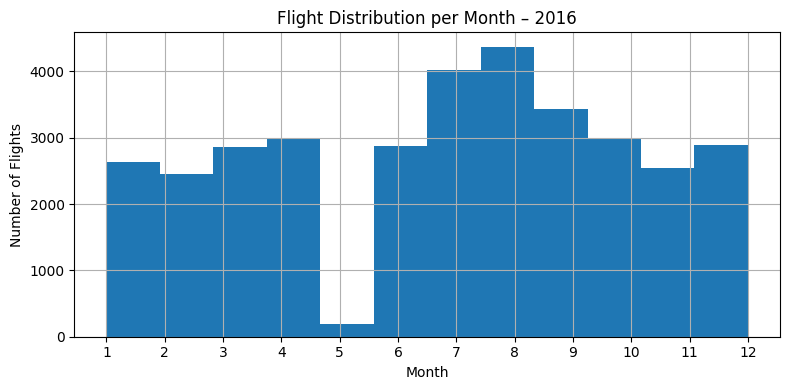

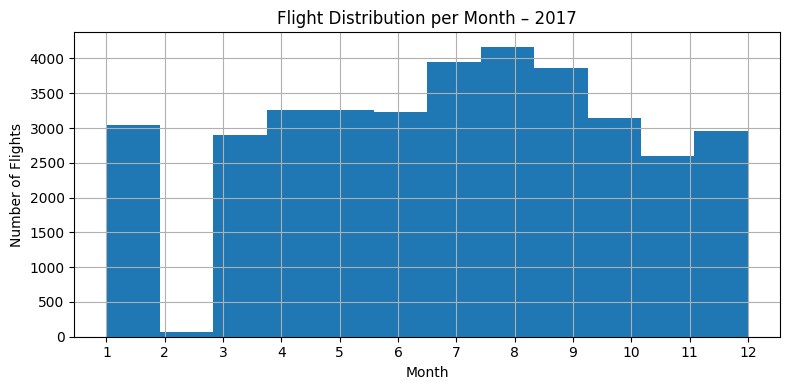

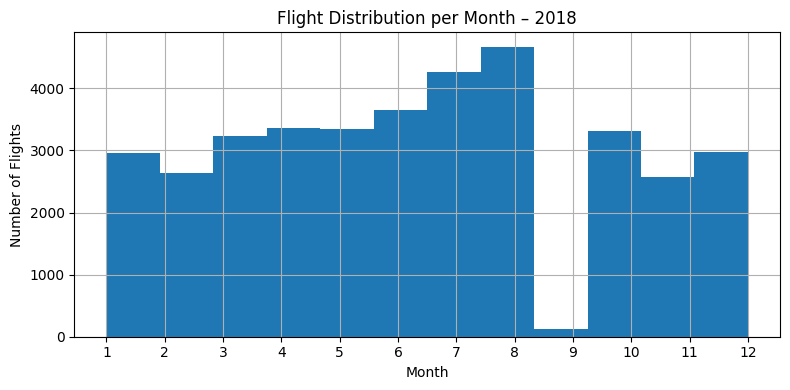

In [69]:

print(df['DATOP_year'].unique())

col_entries = [2016, 2017, 2018]

for i in col_entries:
    plt.figure(figsize=(8, 4))
    df_year = df[df['DATOP_year'] == i]
    df_year['DATOP_month'].hist(bins=12)
    plt.title(f"Flight Distribution per Month – {i}")
    plt.xlabel("Month")
    plt.ylabel("Number of Flights")
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

[2016 2017 2018]


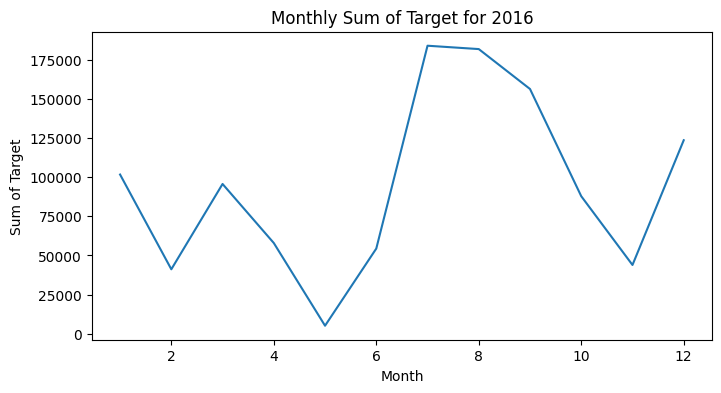

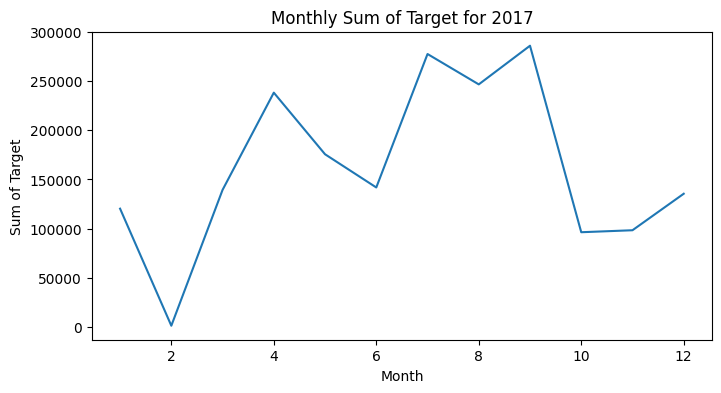

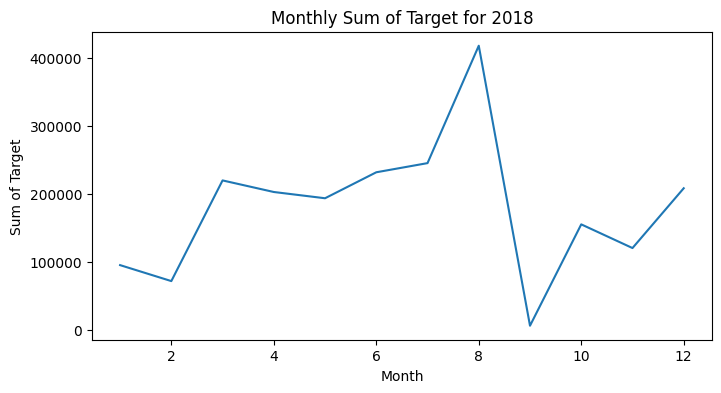

In [70]:

print(df['DATOP_year'].unique())

col_entries = [2016, 2017, 2018]

for i in col_entries:
    plt.figure(figsize=(8, 4))
    df_year = df[df['DATOP_year'] == i]
    df_year.groupby('DATOP_month')['target'].sum().plot(
    kind='line', 
    title=f'Monthly Sum of Target for {i}', 
    xlabel='Month', 
    ylabel='Sum of Target'
)

In [71]:
y = df.target
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)


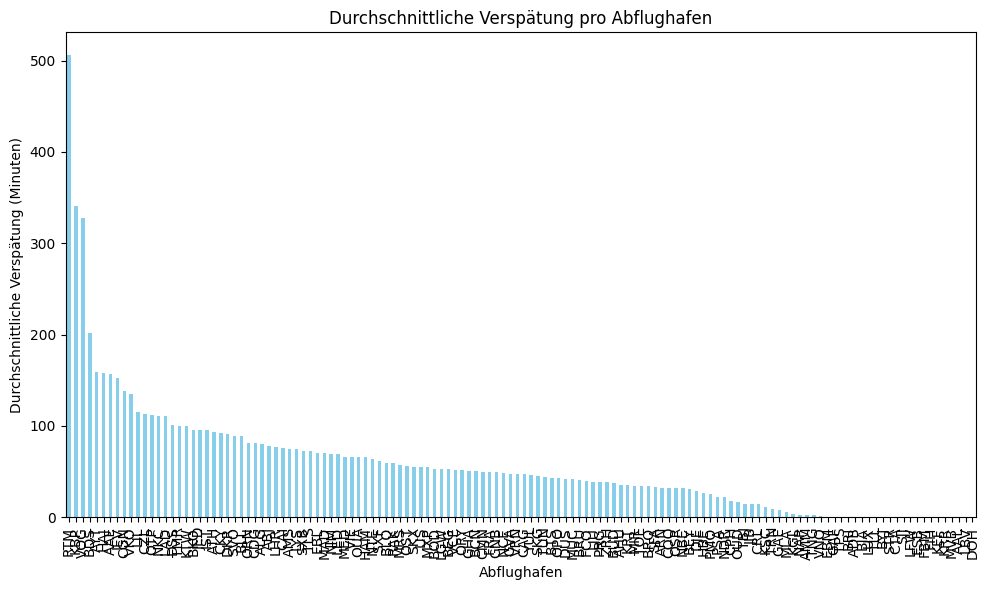

In [72]:
# die Verteilung der Verspätungen unter Abluegen und Ankuenften
# Durchschnittliche Verspätung pro Abflughafen
dep_delay = df.groupby('DEPSTN')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
dep_delay.plot(kind='bar', color='skyblue')
plt.title("Durchschnittliche Verspätung pro Abflughafen")
plt.xlabel("Abflughafen")
plt.ylabel("Durchschnittliche Verspätung (Minuten)")
plt.tight_layout()
plt.show()


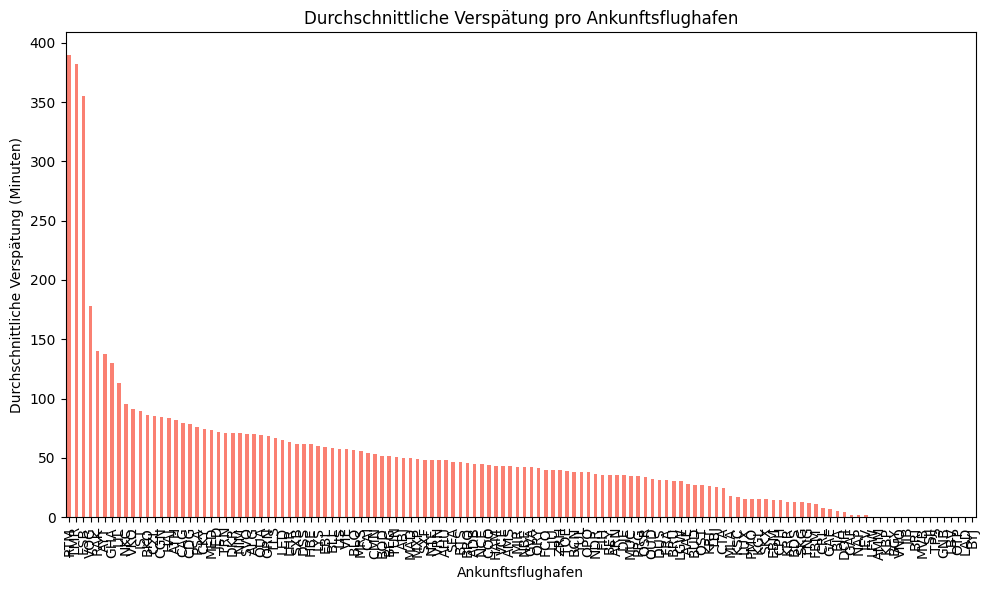

In [73]:
# Durchschnittliche Verspätung pro Ankunftsflughafen
arr_delay = df.groupby('ARRSTN')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
arr_delay.plot(kind='bar', color='salmon')
plt.title("Durchschnittliche Verspätung pro Ankunftsflughafen")
plt.xlabel("Ankunftsflughafen")
plt.ylabel("Durchschnittliche Verspätung (Minuten)")
plt.tight_layout()
plt.show()


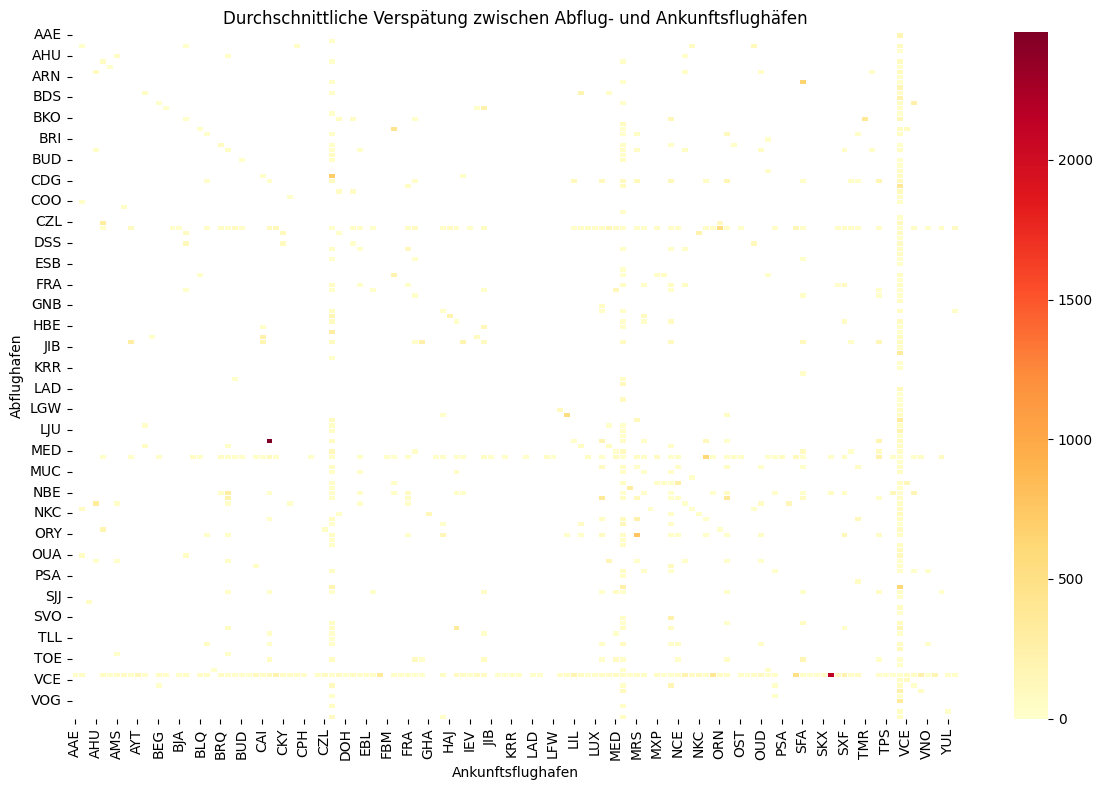

In [75]:
# Pivot-Tabelle für Heatmap
route_delay = df.pivot_table(index='DEPSTN', columns='ARRSTN', values='target', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(route_delay, cmap="YlOrRd", linewidths=0.5, annot=False)
plt.title('Durchschnittliche Verspätung zwischen Abflug- und Ankunftsflughäfen')
plt.xlabel('Ankunftsflughafen')
plt.ylabel('Abflughafen')
plt.tight_layout()
plt.show()



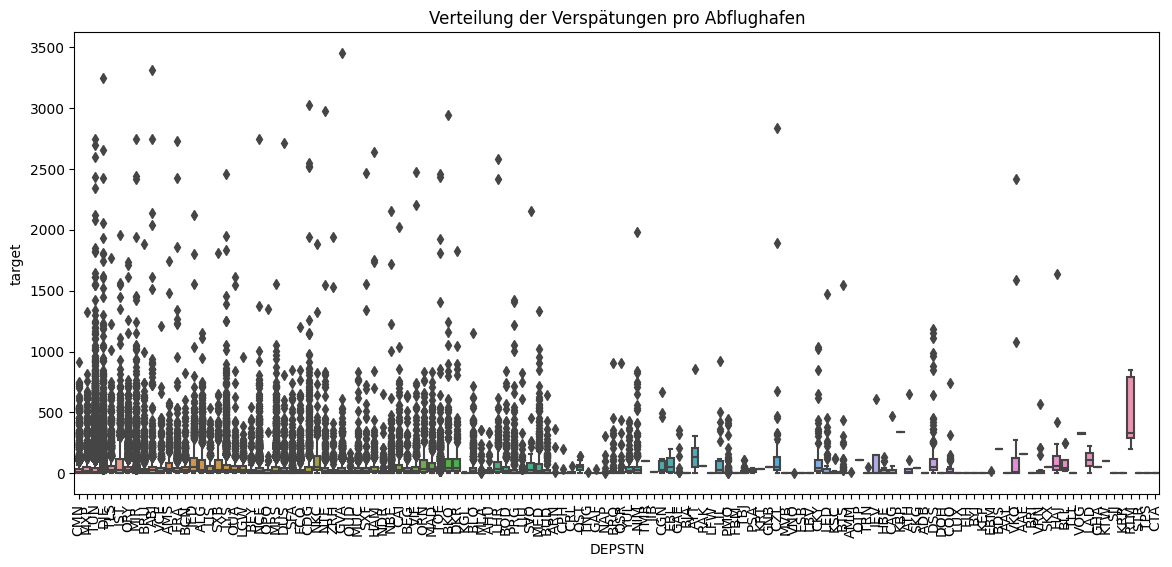

In [76]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="DEPSTN", y="target", data=df)
plt.title("Verteilung der Verspätungen pro Abflughafen")
plt.xticks(rotation=90)
plt.show()


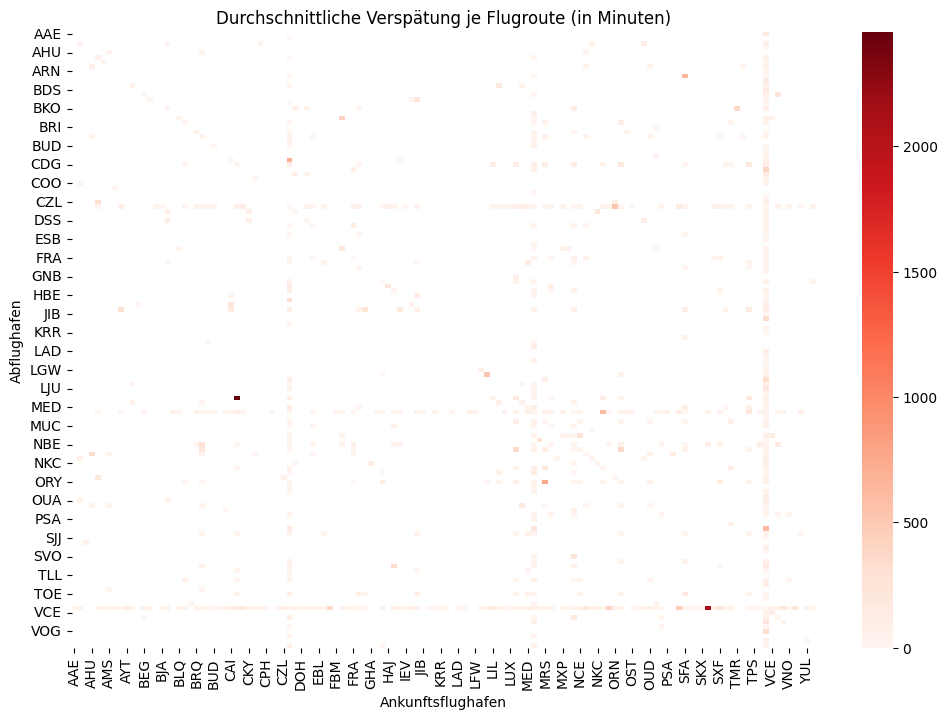

In [77]:
pivot = df.pivot_table(index='DEPSTN', columns='ARRSTN', values='target', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=False, cmap='Reds')
plt.title("Durchschnittliche Verspätung je Flugroute (in Minuten)")
plt.xlabel("Ankunftsflughafen")
plt.ylabel("Abflughafen")
plt.show()


In [78]:
top_dep = df['DEPSTN'].value_counts().head(10)
avg_delay_dep = df.groupby('DEPSTN')['target'].mean().loc[top_dep.index]

summary = pd.DataFrame({'Fluganzahl': top_dep, 'Ø Verspätung (Min.)': avg_delay_dep})
print(summary)


        Fluganzahl  Ø Verspätung (Min.)
DEPSTN                                 
TUN          42522            44.489723
DJE          10252            28.301014
ORY           6755            51.763138
MIR           5248            34.521341
MRS           2845            57.414763
LYS           2358            74.375742
NCE           2227            48.718904
ALG           1573            80.454545
MXP           1534            54.550196
IST           1442            95.541609


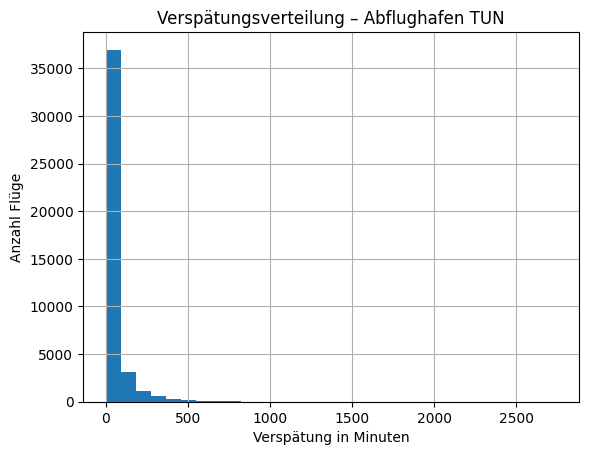

In [79]:
df[df['DEPSTN'] == 'TUN']['target'].hist(bins=30)
plt.title("Verspätungsverteilung – Abflughafen TUN")
plt.xlabel("Verspätung in Minuten")
plt.ylabel("Anzahl Flüge")
plt.show()


# Data cleaningin and feature engineering

In [5]:
coffee_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             28 non-null     int64  
 1   Species                28 non-null     object 
 2   Owner                  28 non-null     object 
 3   Country.of.Origin      28 non-null     object 
 4   Farm.Name              25 non-null     object 
 5   Lot.Number             6 non-null      object 
 6   Mill                   20 non-null     object 
 7   ICO.Number             17 non-null     object 
 8   Company                28 non-null     object 
 9   Altitude               25 non-null     object 
 10  Region                 26 non-null     object 
 11  Producer               26 non-null     object 
 12  Number.of.Bags         28 non-null     int64  
 13  Bag.Weight             28 non-null     object 
 14  In.Country.Partner     28 non-null     object 
 15  Harvest.

In [6]:
#for this exercise we will only deal with numeric variables

X = coffee_features.select_dtypes(['number'])

## Splitting data for testing 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [8]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_train["altitude_mean_log"] = np.log(X_train["altitude_mean_meters"])
X_train.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_train.drop(['Quakers'], axis=1, inplace=True)
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 17 to 6
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number.of.Bags        22 non-null     int64  
 1   Harvest.Year          22 non-null     int64  
 2   Fragrance...Aroma     22 non-null     float64
 3   Flavor                22 non-null     float64
 4   Aftertaste            22 non-null     float64
 5   Salt...Acid           22 non-null     float64
 6   Bitter...Sweet        22 non-null     float64
 7   Mouthfeel             22 non-null     float64
 8   Uniform.Cup           22 non-null     float64
 9   Clean.Cup             22 non-null     float64
 10  Balance               22 non-null     float64
 11  Cupper.Points         22 non-null     float64
 12  Total.Cup.Points      22 non-null     float64
 13  Moisture              22 non-null     float64
 14  Category.One.Defects  22 non-null     int64  
 15  Category.Two.Defects  22 

In [10]:
altitude_low_meters_mean = X_train["altitude_low_meters"].mean()
altitude_high_meters_mean = X_train["altitude_high_meters"].mean()
altitude_mean_log_mean = X_train["altitude_mean_log"].mean()

In [11]:
# fillna with mean.. 
X_train["altitude_low_meters"] = X_train["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_train["altitude_high_meters"] = X_train["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_train["altitude_mean_log"] = X_train["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [12]:
print(f"altitude low meters mean is {altitude_low_meters_mean}")
print(f"altitude_high_meters_mean is {altitude_high_meters_mean}")
print(f"altitude_mean_log_mean is {altitude_mean_log_mean}")

altitude low meters mean is 1500.3684210526317
altitude_high_meters_mean is 1505.6315789473683
altitude_mean_log_mean is 7.0571530664031155


## Trainining the model

In [13]:
## in order to exemplify how the predict will work.. we will save the y_train
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")